In [1]:
import numpy as np

from neurodsp.utils.norm import normalize_sig
from neurodsp.spectral import compute_spectrum

from timescales.fit import ACF, PSD
from timescales.conversions import convert_knee
from timescales.sim import sim_spikes_synaptic, sim_branching
from timescales.plts import set_default_rc

import matplotlib.pyplot as plt
set_default_rc()

# Figure 1. PSD & ACF

Below, timescales are simulated in the LFP as a branching simulation and in spike trains from exponentially decaying probability distributions. Power spectral density is estimated from an AR(10) model. This produces a more stable PSD estimate than non-parameteric methods, such as Welch's method. The ACF is then computed from the inverse Fourier transform of the autoregressive spectrum. Timescales are quantified using a Lorentzian PSD model and an exponentially decaying ACF model. 

#### Settings

In [2]:
# Simulation settings
np.random.seed(0)

n_seconds = 20
n_seconds_plot = .25

tau = convert_knee(10)

#### Simulations

In [3]:
# Simulate spikes
fs_spikes = 10000
times_spikes = np.arange(0, n_seconds, 1/fs_spikes)

spikes = sim_spikes_synaptic(n_seconds, fs_spikes, tau, mu=500)

# Simulate LFP
fs = 1000
times = np.arange(0, n_seconds, 1/fs)

lfp = sim_branching(n_seconds, fs, tau, 20)
lfp = normalize_sig(lfp, 0, 1)

# Bin spikes
nlags = 2000
bin_size = 10
spikes_bin = spikes.reshape(-1, bin_size).sum(axis=1)
spikes_bin = normalize_sig(spikes_bin, 0, 1)

# Get spike time array for plotting
spike_times = times_spikes[np.where(spikes)[0]]
spike_times = spike_times[np.where(spike_times <= n_seconds_plot)[0]]

#### PSD & ACF

In [4]:
# Compute PSD
ar_order = 10
norm_range = (.01, 1)
f_range = (1, 100)

psd_spikes = PSD()
psd_spikes.compute_spectrum(spikes_bin, fs, f_range=f_range,
                            norm_range=norm_range, ar_order=ar_order, nfft=20000)
psd_spikes.fit()

psd_lfp = PSD()
psd_lfp.compute_spectrum(lfp, fs, f_range=f_range, norm_range=norm_range,
                         ar_order=ar_order, nfft=20000)
psd_lfp.fit()

In [5]:
# Compute ACF
nlags = 100
norm_range = (0, 1)
psd_kwargs = dict(ar_order=ar_order, nfft=20000, norm_range=norm_range)

acf_spikes = ACF()
acf_spikes.compute_acf(spikes_bin, fs, nlags=nlags, from_psd=True,
                       psd_kwargs=psd_kwargs)
acf_spikes.fit()

acf_lfp = ACF()
acf_lfp.compute_acf(lfp, fs, nlags=nlags, from_psd=True,
                    psd_kwargs=psd_kwargs)
acf_lfp.fit()

In [6]:
print('Ground Truth   :  10.0 Hertz\n')
print('PSD Spikes Knee: ', psd_spikes.knee_freq.round(2), 'Hertz')
print('PSD LFP    Knee: ', psd_lfp.knee_freq.round(2), 'Hertz')
print('ACF Spikes Knee: ', acf_spikes.knee_freq.round(2), 'Hertz')
print('ACF LFP    Knee: ', acf_lfp.knee_freq.round(2), 'Hertz')

Ground Truth   :  10.0 Hertz

PSD Spikes Knee:  9.91 Hertz
PSD LFP    Knee:  10.06 Hertz
ACF Spikes Knee:  9.84 Hertz
ACF LFP    Knee:  9.86 Hertz


#### Plot

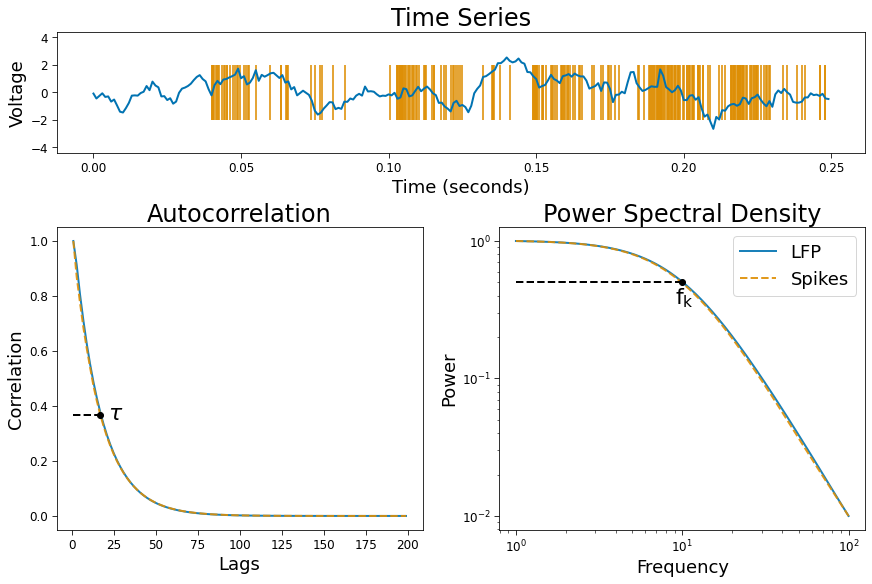

In [7]:
# Spikes
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = plt.GridSpec(7, 2, figure=fig)

ax0 = fig.add_subplot(gs[0:2, :])
ax1 = fig.add_subplot(gs[2:7, 0])
ax2 = fig.add_subplot(gs[2:7, 1])
ax0.plot(times[:int(fs*n_seconds_plot)], lfp[:int(fs*n_seconds_plot)])
ax0.eventplot(spike_times, color='C1', alpha=.8, lineoffsets=0,
              linelengths=4, zorder=1)

# ACF
ax1.plot(acf_lfp.lags, acf_lfp.corrs, zorder=1, alpha=.9)
ax1.plot(acf_spikes.lags, acf_spikes.corrs, zorder=1, alpha=.9, ls='--')

# PSD
ax2.loglog(psd_lfp.freqs, psd_lfp.powers, label='LFP', alpha=.9)
ax2.loglog(psd_spikes.freqs, psd_spikes.powers, label='Spikes', alpha=.9, ls='--')
ax2.legend()

# Ground truth
y_psd = psd_lfp.powers[np.where(psd_lfp.freqs == 10)[0]]
x_psd = 10

x_acf = (tau * fs)+1
y_acf = np.exp(-1)

ax1.scatter(x_acf, y_acf, zorder=2, color='k')
ax2.scatter(x_psd, y_psd, zorder=2, color='k')

ax1.text(x_acf+5, .35, r'$\tau$', size=22)
ax2.text(x_psd-1, .35, r'$\mathregular{f_k}$', size=22)

ax1.axhline(y=y_acf, xmin=.045, xmax=.12, ls='--', color='k')
ax2.axhline(y=y_psd, xmin=.045, xmax=.5, ls='--', color='k')

# Titles and axis labels
ax0.set_title('Time Series')
ax1.set_title('Autocorrelation')
ax2.set_title('Power Spectral Density')

ax0.set_ylabel('Voltage')
ax0.set_xlabel('Time (seconds)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation')

ax2.set_xlabel('Frequency')
ax2.set_ylabel('Power')

plt.savefig('fig01_acf_vs_psd.png', dpi=300, facecolor='w');